In [1]:
import random

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
import seaborn as sns
from shapely import geometry
from tqdm import notebook

sns.set_style('white')  # plot styles

In [2]:
trip_csv_filepath = '../data/interim/yaounde-trips.csv'
# trip_crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'
trip_crs = 'epsg:4326'
buffer_dist = 100

In [3]:
# read trip csv and transform origin/dest columns to geometries
trip_df = pd.read_csv(trip_csv_filepath, index_col=0)

In [4]:
len(trip_df)

23712

In [5]:
trip_gdf = trip_df.copy()
for loc_column in ['origin', 'dest']:
    trip_gdf[loc_column] = gpd.points_from_xy(
        trip_gdf[f'{loc_column}_lon'], trip_gdf[f'{loc_column}_lat'])
    trip_gdf = trip_gdf.drop([f'{loc_column}_lon', f'{loc_column}_lat'], axis=1)
# since we are most interested in the trip destinations, let us set the
# destination point as the reference geometry of `trip_gdf`
trip_gdf = trip_gdf.set_geometry('dest')
    
# let us just select a subset of such trips based on the location of their
# destination
west, south, east, north = 11.4, 3.8, 11.5, 3.85
trip_gdf = trip_gdf[trip_gdf.within(geometry.box(west, south, east, north))]

In [6]:
len(trip_gdf)

8943

In [7]:
trip_gdf.head()

,origin_dt,dest_dt,neighborhood,origin,dest
415,2018-02-07 09:01:12,2018-02-07 09:45:09,Nkozoa,POINT (11.540371 3.965306),POINT (11.47033 3.83131)
416,2018-02-07 12:06:37,2018-02-07 12:13:16,Nkozoa,POINT (11.471801 3.834358),POINT (11.48885 3.83186)
422,2018-02-07 13:52:37,2018-02-07 14:15:07,Nkozoa,POINT (11.504751 3.867998),POINT (11.47140 3.82584)
423,2018-02-07 14:17:26,2018-02-07 14:22:03,Nkozoa,POINT (11.471725 3.824733),POINT (11.45961 3.80135)
424,2018-02-07 15:08:45,2018-02-07 15:22:56,Nkozoa,POINT (11.459691 3.80134),POINT (11.48888 3.83142)


In [8]:
# get convex hull in lat/long to query OSM
convex_hull = trip_gdf['dest'].unary_union.convex_hull
# get the street network and project it
G = ox.graph_from_polygon(convex_hull, network_type='drive')
# the undirected graph will do for our purposes
G = ox.project_graph(G.to_undirected(reciprocal=False))

In [9]:
len(G.nodes), len(G.edges)

(4032, 5344)

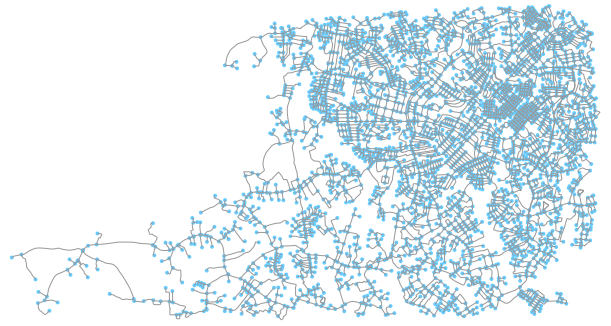

In [10]:
fig, ax = ox.plot_graph(G)

In [11]:
for loc_column in ['origin', 'dest']:
    loc_gdf = gpd.GeoDataFrame(geometry=trip_gdf[loc_column])
    loc_gdf.crs = trip_crs
    trip_gdf[loc_column] = ox.project_gdf(loc_gdf)

In [12]:
point = trip_gdf.iloc[0]['dest']
point_buffer = point.buffer(buffer_dist)

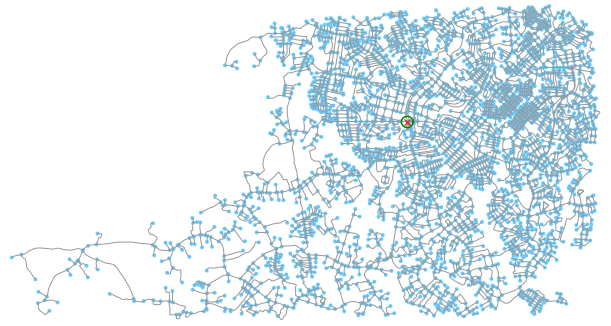

In [13]:
# fig, ax = plt.subplots()
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.plot(point.x, point.y, 'x', color='r')
ax.plot(*point_buffer.exterior.xy, color='g')
plt.show()

In [14]:
def get_buffer_street_length(point, buffer_dist, G):
    geom = point.buffer(buffer_dist)
    try:
        buffer_G = ox.truncate_graph_polygon(G, geom, truncate_by_edge=True,
                                             retain_all=True)
        return sum([d['length'] for u, v, d in buffer_G.edges(data=True)])
    except:
        return 0

In [15]:
%%time
street_length = get_buffer_street_length(point, buffer_dist, G)

CPU times: user 30.3 s, sys: 25.2 ms, total: 30.3 s
Wall time: 30.3 s


## First step: spatial join

In [16]:
# left geo-data frame
# add a buffer around the point geometries
buffer_gdf = gpd.GeoDataFrame(
    geometry=trip_gdf['dest'].apply(lambda p: p.buffer(buffer_dist)),
    index=trip_gdf.index)
buffer_gdf.crs = G.graph['crs']

# right geo-data frame
# get list of nodes from the projected graph
node_geom = [
    geometry.Point(data['x'], data['y']) for _, data in G.nodes(data=True)
]
# create a GeoDataFrame with the node ids and their respective point geometries
node_gdf = gpd.GeoDataFrame(
    {
        'node': pd.Series(G.nodes()),
        'geometry': node_geom
    }, crs=G.graph['crs'])

In [17]:
buffer_gdf.head()

,geometry
415,"POLYGON ((774460.018 423876.374, 774459.536 42..."
416,"POLYGON ((776518.778 423943.515, 776518.296 42..."
422,"POLYGON ((774580.893 423272.083, 774580.411 42..."
423,"POLYGON ((773278.951 420558.939, 773278.470 42..."
424,"POLYGON ((776522.477 423894.513, 776521.995 42..."


In [18]:
sjoin_gdf = gpd.sjoin(buffer_gdf, node_gdf, op='contains')
for trip_index, group_gdf in sjoin_gdf.groupby(sjoin_gdf.index):
    break

In [19]:
group_gdf

,geometry,index_right,node
415,"POLYGON ((774460.018 423876.374, 774459.536 42...",619,5795317038
415,"POLYGON ((774460.018 423876.374, 774459.536 42...",2962,2322601884
415,"POLYGON ((774460.018 423876.374, 774459.536 42...",2970,2322601912
415,"POLYGON ((774460.018 423876.374, 774459.536 42...",2974,2322601917


## Compute the street length with group by and apply

In [20]:
# get street length
# first define function to compute street length given a list of nodes from
# G that fall within the buffer extent
def get_street_length(nodes, G):
    buffer_G = G.subgraph(nodes)
    return sum([
        d['length'] for u, v, d in buffer_G.edges(data=True)
    ])

In [21]:
%%time
# then, for all origin and destination points:
# 1. perform a spatial join with the nodes of the street network, which
#    will map each polygon (i.e., the spatial buffer around the point) to
#    the set of nodes that the polygon contains
# 2. compute the street length for each polygon
# 3. fill the nan values (polygons that do not contain any street node)
#    with zeroes
sjoin_gdf = gpd.sjoin(buffer_gdf, node_gdf, op='contains')
trip_gdf['street_length'] = sjoin_gdf['node'].groupby(
    sjoin_gdf.index).apply(get_street_length, G)
trip_gdf['street_length'] = trip_gdf['street_length'].fillna(0)

CPU times: user 3.75 s, sys: 39.9 ms, total: 3.79 s
Wall time: 3.79 s


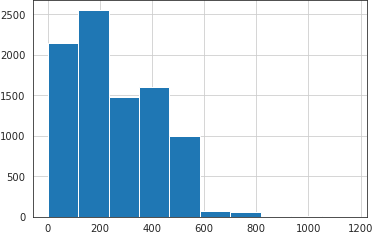

In [22]:
_ = trip_gdf['street_length'].hist()

## Going one step further: including incomplete street segments

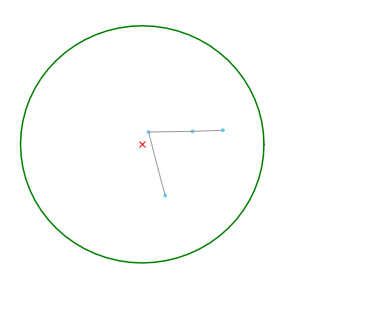

In [23]:
fig, ax = ox.plot_graph(G.subgraph(group_gdf['node']),
                        margin=2,
                        show=False,
                        close=False)
ax.plot(point.x, point.y, 'x', color='r')
ax.plot(*point_buffer.exterior.xy, color='g')
plt.show()

In [24]:
def plot_graph_in_geom(geom, nodes, G):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')
    
    # plot the buffer geometry
    ax.plot(*geom.boundary.xy)

    # iterate over all the edges that involve at least one node of `nodes`
    for u, v, d in G.edges(nodes, data=True):
        node_u = G.nodes[u]
        node_v = G.nodes[v]
        p_u = geometry.Point(node_u['x'], node_u['y'])
        p_v = geometry.Point(node_v['x'], node_v['y'])
        if p_u.within(geom):
            if p_v.within(geom):
                # both nodes are inside `geom`
                plt.plot([node_u['x'], node_v['x']],
                         [node_u['y'], node_v['y']], '-o', color='green')
                continue
            else:
                # `u` is inside `geom` but `v` is outside
                p_in, p_out = p_u, p_v
        else:
            # since the argument `nodes` (that we pass to `subgraph` above)
            # comes from the spatial join we know that at least one node is
            # inside `geom`
            # `v` is inside `geom` but `u` is outside
            p_in, p_out = p_v, p_u

        # if we get here, it is because we have `p_in` inside `geom` and
        # `p_out` outside, otherwise (i.e., both nodes inside `geom`) the
        # `continue` statement would have brought us directly to the next
        # iteration
        intercept = geom.boundary.intersection(
            geometry.LineString([p_in, p_out]))
        ax.plot(p_in.x, p_in.y, 'o', color='green')
        ax.plot([p_in.x, intercept.x], [p_in.y, intercept.y], '-',
                 color='orange')
        ax.plot([intercept.x, p_out.x], [intercept.y, p_out.y], '-',
                 color='red')
        ax.plot(intercept.x, intercept.y, 'o', color='orange')
        ax.plot(p_out.x, p_out.y, 'o', color='red')

    return fig, ax

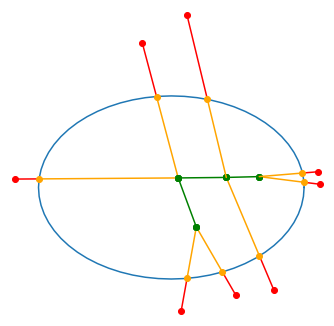

In [25]:
buffer_geom = point.buffer(buffer_dist)
nodes = group_gdf['node']

fig, ax = plot_graph_in_geom(buffer_geom, nodes, G)

In [26]:
def get_graph_in_geom(geom, nodes, G):
    # prepare the new graph
    # the `MultiGraph` type and the 'crs' and 'name' attributes are needed to
    # plot with osmnx
    G_in_geom = nx.MultiGraph()
    for attr_key in ['crs', 'name']:
        G_in_geom.graph[attr_key] = G.graph[attr_key]
    G_in_geom.add_nodes_from(G.subgraph(nodes).nodes(data=True))

    # iterate over all the edges that involve at least one node of `nodes`
    for u, v, d in G.edges(nodes, data=True):
        node_u = G.nodes[u]
        node_v = G.nodes[v]
        p_u = geometry.Point(node_u['x'], node_u['y'])
        p_v = geometry.Point(node_v['x'], node_v['y'])
        if p_u.within(geom):
            if p_v.within(geom):
                # both nodes are inside `geom`
                G_in_geom.add_edge(u, v, length=d['length'])
                continue
            else:
                # `u` is inside `geom` but `v` is outside
                node_in_id, node_out_id = node_u['osmid'], node_v['osmid']
                p_in, p_out = p_u, p_v
        else:
            # since the argument `nodes` (that we pass to `subgraph` above)
            # comes from the spatial join we know that at least one node is
            # inside `geom`
            # `v` is inside `geom` but `u` is outside
            node_in_id, node_out_id = node_v['osmid'], node_u['osmid']
            p_in, p_out = p_v, p_u

        # if we get here, it is because we have `p_in` inside `geom` and
        # `p_out` outside, otherwise (i.e., both nodes inside `geom`) the
        # `continue` statement would have brought us directly to the next
        # iteration
        intercept = geom.boundary.intersection(
            geometry.LineString([p_in, p_out]))

        # compute the distance between the node inside `geom` and the
        # interception between the edge and `geom`
        dist = p_in.distance(intercept)
        # add the node for the interception with the same id as the node
        # that is outside of `geom`
        G_in_geom.add_node(node_out_id, x=intercept.x, y=intercept.y)
        # add an edge from the node inside `geom` to the interception
        G_in_geom.add_edge(node_in_id, node_out_id, length=dist)

    return G_in_geom

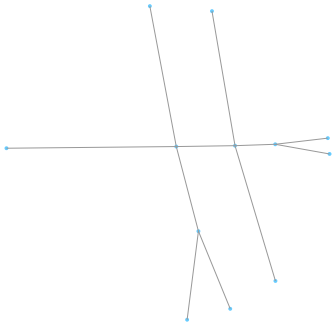

In [27]:
G_in_geom = get_graph_in_geom(buffer_geom, nodes, G)

fig, ax = ox.plot_graph(G_in_geom)

In [28]:
%%time
G_list = []
for trip_index, group_gdf in notebook.tqdm(sjoin_gdf.groupby(sjoin_gdf.index)):
    buffer_geom = group_gdf.iloc[0]['geometry']
    nodes = group_gdf['node']

    G_in_geom = get_graph_in_geom(buffer_geom, nodes, G)
    G_list.append(G_in_geom)


CPU times: user 41.8 s, sys: 329 ms, total: 42.2 s
Wall time: 41.8 s


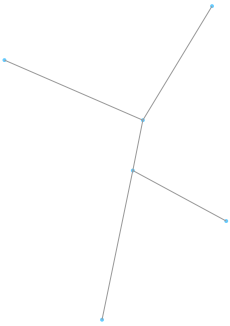

In [29]:
fig, ax = ox.plot_graph(random.choice(G_list))

In [30]:
def compute_street_length(G):
    return sum([d['length'] for u, v, d in G.edges(data=True)])

In [31]:
%%time
street_lengths = []
for G_in_geom in notebook.tqdm(G_list):
    street_lengths.append(compute_street_length(G_in_geom))


CPU times: user 369 ms, sys: 56.1 ms, total: 425 ms
Wall time: 283 ms


In [32]:
# index = sjoin_gdf.groupby(sjoin_gdf.index).first().index
street_length_ser = pd.Series(street_lengths)

Text(0.5, 1.0, 'Differences')

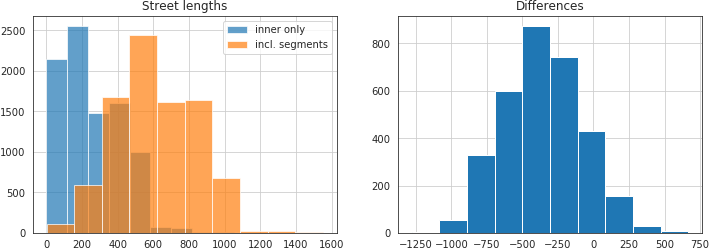

In [33]:
figwidth, figheight = plt.rcParams['figure.figsize']
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))

# left plot
alpha = 0.7  # to overlay histograms
trip_gdf['street_length'].hist(alpha=alpha, label='inner only', ax=ax_l)
street_length_ser.hist(alpha=alpha, label='incl. segments', ax=ax_l)
ax_l.legend()
ax_l.set_title('Street lengths')

# right plot
diff_ser = trip_gdf['street_length'] - street_length_ser
diff_ser.hist(ax=ax_r)
ax_r.set_title('Differences')

In [34]:
diff_ser.mean()

-355.92344200811596